In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, order_poly_ZNE, order_poly_instance, converge_ZNE_order, gaussian_ZNE, converge_ZNE_loocv


from tqdm import tqdm
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from functions_util import cetina_thermal_exp, cetina_envelope_exp,calibrate_sim_Omegas
from samplers_util import thermal_rejection

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
data_file = np.load('Figure_2_full_data_ZNE.npz')
x = data_file['x']
y = data_file['y']
print(y.shape)
y_error = data_file['y_error']
y_ideal = data_file['y_ideal']
times = data_file['times']
ZNE_results = data_file['ZNE_results']
ZNE_error = data_file['ZNE_error']
dense_x = data_file['dense_x']
ZNE_y_dense = data_file['ZNE_y_dense']

(500, 7)


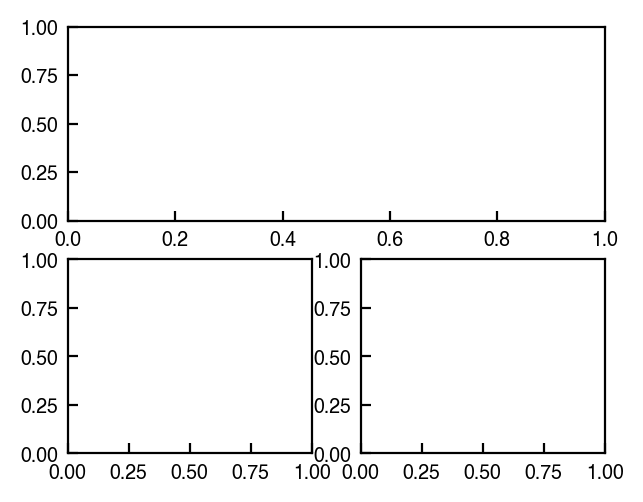

In [3]:
import matplotlib as mpl

columns = 1
rows = 2
#scol=(3+3/8) #single column width of PRL,
#dcol=2*scol # double column,
#size_col = [scol, dcol][columns-1]
#size_row = [scol, dcol][rows-1]
mmtoinch = 1/25.4
scol = 88 * mmtoinch
dcol = 180 * mmtoinch
size_col = [scol, dcol][columns-1]
if columns == 1:
    size_row = scol*rows
else:
    size_row = dcol*rows

fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
cm_subsection = np.linspace(0.2, 1.0, 5)
Reds = [ cm.Reds(x) for x in cm_subsection ]
mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 7,
    "legend.frameon": True,
    "figure.dpi":200,
    "figure.figsize": [size_col, size_row * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
fig = plt.figure()
gs = gridspec.GridSpec(3,2)  # 2x2 grid
ax_a = fig.add_subplot(gs[:2])
ax_bi = fig.add_subplot(gs[2])
ax_bii = fig.add_subplot(gs[3])



In [4]:
#Load in the Rydberg data:
#stagmag_averaged = np.load("stagmag_averaged_old.npy")
#thetas = np.load("thetas.npy")
#thetas = np.power(thetas, 2)
#times = np.load("times.npy")
shots = 600
#Normalize stagmag_averaged to 0 and 1:
#stagmag_normalized = stagmag_averaged*0.5 + 0.5

#stagmag_std = (stagmag_normalized*(1-stagmag_normalized)/shots)**0.5



#print(stagmag_averaged.shape)
#print(times.shape)
#indexed as [theta, time] with sizes 100, 500

cmap = cm.get_cmap('Reds', 100)
#only use the range 0.5 - 1
colors = cmap(np.linspace(0.3, 1, 100))
#baseline = np.power(0.03,2)
#Get the index in thetas closest to baseline:
#baseline_index = np.argmin(np.abs(thetas - baseline))
#factors = [1, 1.1, 1.3, 1.6, 2, 2.5, 3]#, 3.5, 4, 4.5, 5]
#factors = np.array([1.0, 1.0810140527710055, 1.3174929343376374, 1.6902785321094298, 2.1691699739962274, 2.71537032345343])

#factors = np.linspace(1, 3, 10)
#Get the indexes of the factors * the baseline
#indexes = [np.argmin(np.abs(thetas - baseline*factor)) for factor in factors]
#print([np.abs(thetas - baseline*factor) for factor in factors])
#indexes = np.unique(indexes)
#print(baseline)
#print(indexes)
#print(indexes)
#indexes_mask = [i in indexes for i in range(len(thetas))]
#print(thetas[indexes_mask])
# print()

#x_data = thetas[indexes_mask]
#y_data = stagmag_averaged[indexes_mask]
#y_std = stagmag_std[indexes_mask]
#y_ideal = stagmag_averaged[0]
#Save x, y, y_error, y_ideal
#np.savez("Figure_2_data.npz", x=x_data, y=y_data, y_error=y_std, y_ideal=y_ideal, times=times)



#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(np.array(factors)*baseline)))
#sm.set_array([])
#Add a label to the color bar:
#cbar = fig.colorbar(sm, ax=ax_a)
#ax_a.plot(times, stagmag_averaged[-1], color=colors[-1], label=r"$\theta = {}$".format(thetas[-1]))

/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_66581/1725657254.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds', 100)


In [5]:

def create_linear_function(y_at_0_5):
    # Given points
    x1, y1 = 0.5, y_at_0_5
    x2, y2 = 1, 1
    
    # Calculate slope (a) and intercept (b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    
    # Return the linear function
    def linear_function(x):
        return a * x + b
    
    return linear_function

linear_func = create_linear_function(0.5)
#actual_x 



normalized_ZNE_points_for_color = linear_func(x/max(x))
#cm_subsection = np.linspace(0.2, 1.0, len(ZNE_points) )
Reds = [ cm.Reds(x) for x in normalized_ZNE_points_for_color ]
cmap = LinearSegmentedColormap.from_list('name', Reds)

colors = Reds#cmap(np.linspace(0, 1, len(ZNE_points)))

colorbar = plt.cm.ScalarMappable(cmap=cmap)

# Add color bar to ax_bii
#test_ticks = normalized_ZNE_points_for_color
test_labels = np.asarray([0.0005,  0.001, 0.0015, 0.002, 0.0025])#np.power(np.array([0.04, 0.05, 0.06, 0.07]),2)


test_ticks = linear_func(test_labels/max(x))
#labels = np.array(['{:.4f}'.format(test_labels[i-1]) for i in range(1,len(ZNE_points))])
print(test_ticks)
#ticks_test = linear_func(test_labels/((max(actual_x))**2))
cbar = plt.colorbar(colorbar, ax=ax_a, ticks=test_ticks)#normalized_ZNE_points_for_color[1:])
cbar.set_ticklabels(test_labels)
print(test_ticks)
print(test_labels/max(x))
#Padd colors so that the the colors[index[i]] corresponds to the correct colors[i] currently. There should be 100 total:
colors_padded = np.zeros((100, 4))
#for i in range(len(indexes)):
#    colors_padded[indexes[i]] = colors[i]
print(colors_padded)

ax_a.plot(times, y_ideal, color='black', label=r"Noiseless", ls="--", zorder=1000)
#Fill between:

for i in range(len(x)):
    if i == 0:
        ax_a.plot(times, y[:,i], color=colors[i], lw=0.6, zorder=100-i, label='Experimental')
    else:
        ax_a.plot(times, y[:,i], color=colors[i], lw=0.6, zorder=100-i)



[0.18391899 0.36783798 0.55175697 0.73567595 0.91959494]
[0.18391899 0.36783798 0.55175697 0.73567595 0.91959494]
[0.18391899 0.36783798 0.55175697 0.73567595 0.91959494]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0.

<Figure size 692.913x856.488 with 0 Axes>

In [6]:


current_ylims = ax_a.get_ylim()
ax_a.fill_between(times, ZNE_results-ZNE_error, ZNE_results+ZNE_error, color="blue", alpha=0.1, zorder=-1)
ax_a.plot(times, ZNE_results, color="blue", label="Zero Noise Extrapolation", zorder=-1, lw=0.6)#, linestyle="--")


In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

index_to_plot = 345
#index_to_plot = 245
#ax_a.vlines(times[index_to_plot],-10, 10, linestyle=":")
#Converting this to an inset:

print(times.shape)
print(y.shape)
print(y[0,:].shape)
ax_a.set_ylim(current_ylims)
for i in range(len(x)):
    #WARNING THIS IS HARDCODED
    ax_bi.errorbar(x[i], y[index_to_plot,i], yerr=y_error[index_to_plot,i], color=colors[i], elinewidth=1, capsize=2, capthick=1,markersize = 2, fmt='o', zorder=100-i)

ax_bi.errorbar(x[i], y[index_to_plot,i], yerr=y_error[index_to_plot,i], color=colors[i], label=r"Experimental Points", zorder=100, markersize = 2, fmt='o', elinewidth=1, capsize=2, capthick=1)


subplot_2_ylims = ax_bi.get_ylim()


ax_bi.set_xlim([0-(x[-1])/10, max(x)*1.1])
ax_bi.plot(dense_x, ZNE_y_dense[index_to_plot], color="blue",label='Extrapolating Polynomial', zorder=-1)#, linestyle="--")

ax_bi.errorbar(0, ZNE_results[index_to_plot], yerr=ZNE_error[index_to_plot], color="blue", elinewidth=1, capsize=2, capthick=1, fmt='o', markersize=2)
ax_bi.set_ylim([subplot_2_ylims[0], max([ZNE_y_dense[index_to_plot][0]+0.03, subplot_2_ylims[1], y[index_to_plot,0]*1.05])])

ax_bi.hlines(y_ideal[index_to_plot], 0, x[-1], linestyle="--", color="black", label="Noiseless")



(500,)
(500, 7)
(7,)


In [16]:
#Baseline error:
baseline_error = np.abs(y[:,0] - y_ideal)
ZNE_error = np.abs(ZNE_results - y_ideal)

rolling_accumulated_error = np.cumsum(baseline_error)
rolling_accumulated_ZNE = np.cumsum(ZNE_error)
#ax_bii.plot(times, rolling_accumulated_error, label="Baseline error", color=colors[indexes[0]])#, ls="--")
#ax_bii.plot(times, rolling_accumulated_ZNE, label="ZNE error", color="blue")#, ls="--")

#ax_bii.set_ylabel(r'Cumulative Error', usetex=1)
#ax_bii.set_xlabel(r'Time ($\Omega t$)', usetex=1)
ax_bi.set_ylabel(r'Staggered Magnetization', usetex=1)
ax_a.set_ylabel(r'Staggered Magnetization', usetex=1)
ax_a.set_xlabel(r'Time ($\Omega t$)', usetex=1)
cbar.set_label(r"$\theta=\sigma^2$", labelpad=-10, y=-0, rotation=0, usetex=1)
ax_bi.set_xlabel(r'Noise Strength ($\sigma^2$)', usetex=1)
#ax_a.set_title('PXP Model under Gaussian Noise')


#rolling_max_baseline = np.maximum.accumulate(baseline_error)
#rolling_max_ZNE = np.maximum.accumulate(ZNE_error)
#ax_bii.plot(times, rolling_max_baseline, label="Baseline error", color=colors[baseline_index])
#ax_bii.plot(times, rolling_max_ZNE, label="ZNE error", color="black", ls="--")
#ax_bii.set_yscale("log")
#ax_bii.legend()



Text(0.5, 20.000000000000007, 'Noise Strength ($\\sigma^2$)')

In [17]:
#Get indexes of local maxima of the error np.abs(stagmag_averaged[0])

peak_indices = np.where(np.diff(np.sign(np.diff(np.abs(y_ideal)))) == -2)[0]
#print(peak_indices)
#peak_mask = np.zeros(len(times))
#peak_mask[peak_indices] = 1
#plt.scatter(times[peak_indices], stagmag_averaged[0][peak_indices])
#plt.plot(times, stagmag_averaged[0])
#Peak error:
peak_error = np.abs(y[:,0][peak_indices] - y_ideal[peak_indices])/np.abs(y_ideal[peak_indices])
ZNE_peak_error = np.abs(ZNE_results[peak_indices] - y_ideal[peak_indices])/np.abs(y_ideal[peak_indices])
ax_bii.scatter(times[peak_indices],ZNE_peak_error, label='ZNE error', color="blue",s=5)
ax_bii.scatter(times[peak_indices],peak_error, label='Baseline error', color=colors[0],s=5)
ax_bii.set_yscale("log")
ax_bii.set_ylabel(r'Relative Error', usetex=1)
ax_bii.set_xlabel(r'Time ($\Omega t$)', usetex=1)
#ax_bii.legend(loc="lower right")#Shift to the right
#fig.tight_layout()
#fig.savefig("Figure_2_alt.pdf", bbox_inches='tight')
#fig.savefig("Figure_2_alt.png", bbox_inches='tight', dpi=600)
#fig.savefig("Figure_2_alt.svg", bbox_inches='tight')


Text(0.5, 20.000000000000007, 'Time ($\\Omega t$)')

In [18]:
# ax_z = inset_axes(ax_a, 
#                   width="100%",  # Reduce width to make inset smaller
#                   height="100%", # Reduce height to match
#                   bbox_to_anchor=(x, y, 30.5, 1.97),
#                   bbox_transform=ax_a.transData,  # Use data coordinates
#                   loc='center')

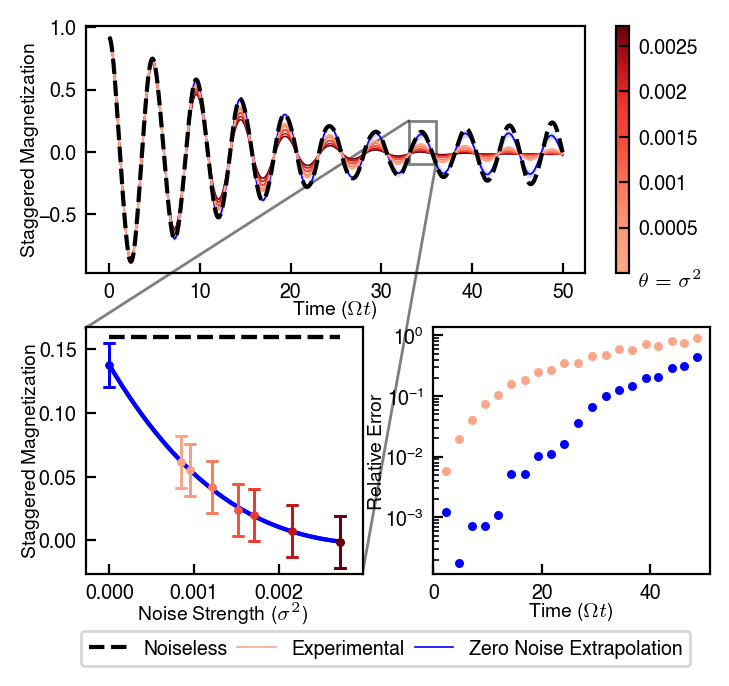

In [19]:
#ax_a.legend()
#ax_bi.legend()
fig.tight_layout(pad=0.01, h_pad=0.2, w_pad=0.2)
ax_a.legend(
    loc='upper center',  # Anchor point for the legend
    bbox_to_anchor=(0.6, -1.45),  # (x, y) coordinates relative to the axes
    ncol=3,  # Keep two columns
    borderaxespad=0,  # Padding between axes and legend
    columnspacing=0.5
)

x, y = -2.6, -3.38  # Position in data coordinates
#ax_z = ax_a.inset_axes([-2.7, -3.38, 30.5, 1.97],
#                  xlim  = (32, 34), ylim= (-0.05, .2))
ax_z = inset_axes(ax_a, 
                  width="100%",  # Reduce width to make inset smaller
                  height="100%", # Reduce height to match
                  bbox_to_anchor=(x, y, 30.5, 1.97),
                  bbox_transform=ax_a.transData,  # Use data coordinates
                  loc='center')
x_inset_range = (33, 36)
y_inset_range = (-.1, 0.25)
ax_z.set_xlim(x_inset_range)
ax_z.set_ylim(y_inset_range)
inset_zoom = ax_a.indicate_inset_zoom(ax_z, edgecolor="k", )
connector_lines = inset_zoom[1]  # The connector lines are returned as a tuple
connector_lines[0].set_visible(False)  # Hide the lower-left connector line
connector_lines[1].set_visible(True)   # Show the upper-left connector line
connector_lines[2].set_visible(True)   # Show the lower-right connector line
#Set the z order and transparaency of the connector line
connector_lines[2].set_zorder(-1)
connector_lines[3].set_visible(False)  # Hide the upper-right connector line
#Turn off all all the axes for ax_z:
ax_z.axis('off')
#Turn EVERYTHING OFF, leave only the connectors:
ax_z.set_xticks([])
ax_z.set_yticks([])
ax_z.set_xticklabels([])
ax_z.set_yticklabels([])
ax_z.set_xlabel("")
ax_z.set_ylabel("")
#ax_z.set_frame_on(False)

#fig.tight_layout()

fig.savefig("Figure_2_v6.pdf")#, bbox_inches='tight')
fig.savefig("Figure_2_v6.png", dpi=600)#, bbox_inches='tight', dpi=600)
fig.savefig("Figure_2_v6.svg")#, bbox_inches='tight')

fig

In [20]:
# fig = plt.figure()
# #Plotting other options for errors:


# import matplotlib as mpl

# columns = 1
# rows = 2
# #scol=(3+3/8) #single column width of PRL,
# #dcol=2*scol # double column,
# #size_col = [scol, dcol][columns-1]
# #size_row = [scol, dcol][rows-1]
# mmtoinch = 1/25.4
# scol = 88 * mmtoinch
# dcol = 180 * mmtoinch
# size_col = [scol, dcol][columns-1]
# if columns == 1:
#     size_row = scol*rows
# else:
#     size_row = dcol*rows

# fullwidth=6.3,
# from matplotlib import cm
# gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
# cm_subsection = np.linspace(0.2, 1.0, 5)
# Reds = [ cm.Reds(x) for x in cm_subsection ]
# mpl.rcParams.update({
#     "ytick.direction": "in",
#     "xtick.direction": "in",
#     "axes.labelpad": 0,
#     "font.size": 7,
#     "legend.frameon": True,
#     "figure.dpi":200,
#     "figure.figsize": [size_col, size_row * gr],
#     "font.family": "Helvetica",
#     #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
#     # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
# })
# gs = gridspec.GridSpec(3,2)  # 2x2 grid
# ax_a = fig.add_subplot(gs[:2])
# ax_bi = fig.add_subplot(gs[2])
# ax_bii = fig.add_subplot(gs[3])


In [21]:
#Create a version that plots the rolling maximum error:
full_error = np.abs(stagmag_averaged[baseline_index] - stagmag_averaged[0])
full_error_ZNE = np.abs(ZNE_data - stagmag_averaged[0])
rolling_max_baseline = np.maximum.accumulate(full_error)
rolling_max_ZNE = np.maximum.accumulate(full_error_ZNE)
ax_bii.scatter(times, rolling_max_baseline, label="Baseline error", color=colors[indexes[0]], s=5)
ax_bii.scatter(times, rolling_max_ZNE, label="ZNE error", color="blue", s=5)
ax_bii.set_yscale("log")
ax_bii.set_ylim(0.001, 0.3)
ax_bii.set_ylabel(r'Maximum Error', usetex=1)
ax_bii.set_xlabel(r'Time ($\Omega t$)', usetex=1)
#ax_bii.legend()


NameError: name 'stagmag_averaged' is not defined